In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import logging
import time
from tqdm import tqdm, notebook

%matplotlib inline

In [2]:
def merge_beta (sumstat, polyfun):
    SNP = sumstat[sumstat.SNP.isin(polyfun.SNP)]
    check_size = pd.merge(SNP, polyfun[polyfun.SNP.isin(SNP.SNP)], on='SNP')
    check_size.rename(columns = {'BETA':'beta_sumstat', 'BETA_MEAN':'beta_polyfun'}, inplace = True)
    return(check_size) 


In [3]:
## create scatter plot and box plot
p_threshold = [0.1,0.01, 0.001,5e-8]
def plot_beta(df, name):
    for i in p_threshold:
        df= df[df.P < i]
        plt.scatter(df.beta_sumstat, df.beta_polyfun, c='blue', alpha=0.3)
        plt.title(name + ' effect size comparison, p = ' + str(i))
        plt.xlabel("summary stat")
        plt.ylabel("polyfun")
        plt.show()
    df.boxplot(column=['beta_sumstat', 'beta_polyfun'])  

In [4]:
kunkle = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/Kunkle_et_al_2019_hg37_ldsc.tsv', sep = '\t')
#kunkle_munged = pd.read_parquet('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/kunkle_et_al_2021_hg37_ldsc.munged.parquet')
kunkle_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/kunkle/kunkle_fixed_0224/finemap/max_snp_10/aggregate.all.txt.gz', compression = 'gzip', sep = '\t', usecols = ['SNP','PIP','BETA_MEAN'])
merge_kunkle = merge_beta(kunkle,kunkle_polyfun)

In [5]:
bellenguez = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/Bellenguez_et_al_2021_hg37_qc.tsv', sep = '\t')
bellenguez_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/bellenguez/bellenguez_fixed_0224/finemap/max_snp_10/sort_aggregate.all.txt', sep = '\t',
                                 names = ['CHR','SNP','BP','A1','A2','SNPVAR','N','Z','P','PIP','BETA_MEAN','BETA_SD','CREDIBLE_SET','start','end'],usecols = ['SNP','PIP','BETA_MEAN'])
bellenguez_polyfun.drop(bellenguez_polyfun.tail(1).index,inplace=True) ## because this one is sorted file, so col name is in the last row. 
merge_bellenguez = merge_beta(bellenguez,bellenguez_polyfun)
merge_bellenguez.beta_polyfun = merge_bellenguez.beta_polyfun.astype(float) ## because beta_polyfun was Object class. Changed it to float so we can plot its value. 
merge_bellenguez.PIP = merge_bellenguez.PIP.astype(float)

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#wightman = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/old/Wightman_2021_hg37_withbeta.tsv', sep = '\t') ## this was wrong because beta was calculated by P instead of p
wightman = pd.read_csv('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/summary_stats/alzheimers/fixed_alzheimers/processed/wightman_fixed_beta_qc.tsv', sep = '\t')
wightman_polyfun = pd.read_csv('/gpfs/commons/home/tlin/output/wightman/wightman_fixed_0224/finemap/max_snp_10/agg_fixed_converge.tsv', sep = '\t', usecols = ['SNP','PIP','BETA_MEAN'])
merge_wightman =  merge_beta(wightman ,wightman_polyfun)


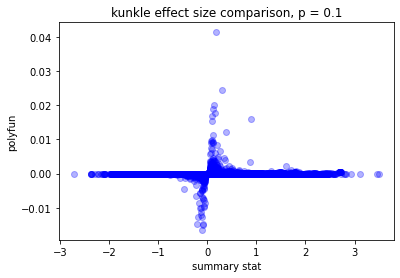

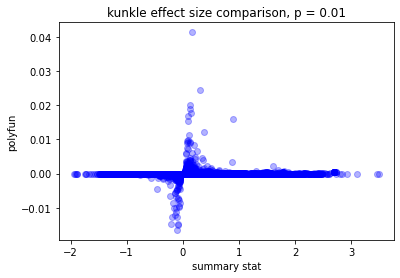

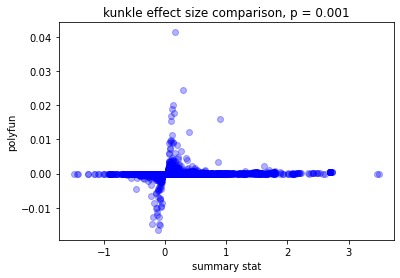

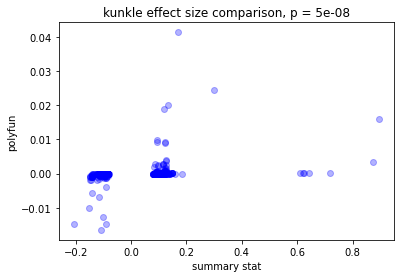

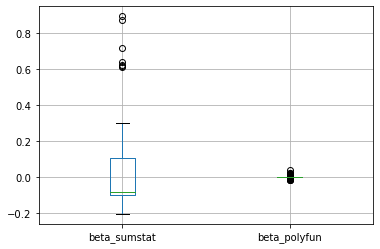

In [10]:
plot_beta(merge_kunkle, 'kunkle')

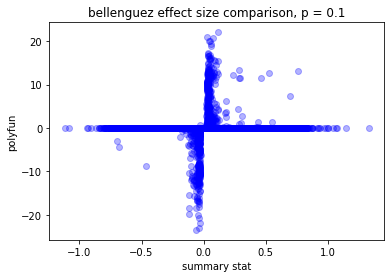

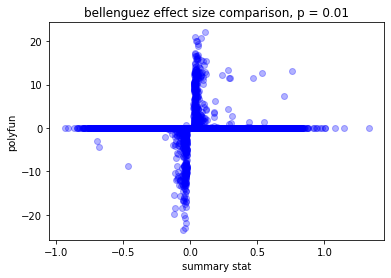

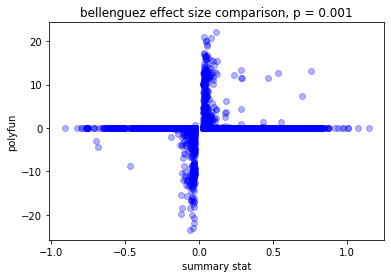

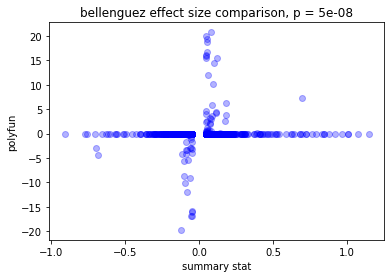

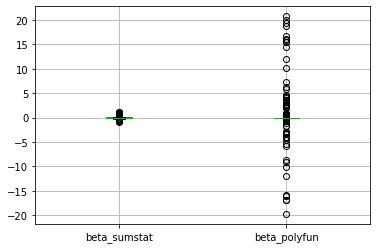

In [12]:
plot_beta(merge_bellenguez,'bellenguez')

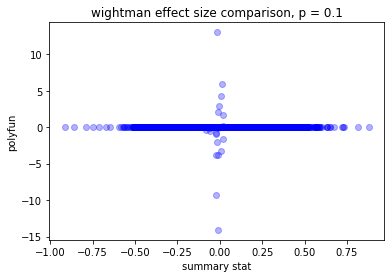

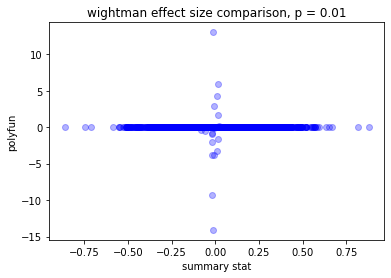

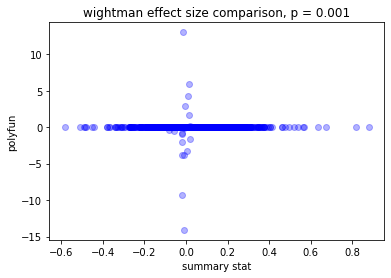

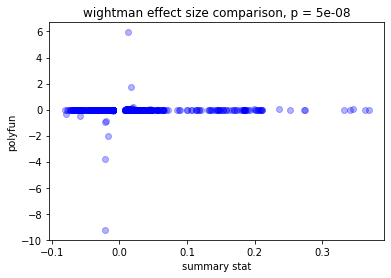

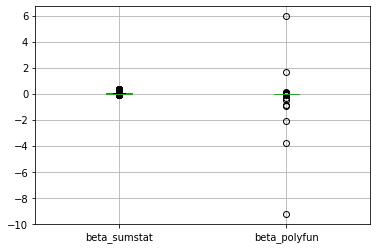

In [9]:
plot_beta(merge_wightman,'wightman')

## check if the beta that was shrinkaged to 0 in polyfun was in high LD with those in the middle (causal effect)

In [7]:
#import logging
def setup_logger(name, log_file, level=logging.INFO):
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    
    handler = logging.FileHandler(log_file)        
    handler.setLevel(logging.INFO)
    
    logger.addHandler(handler)
    formatter = logging.Formatter('%(message)s')
    handler.setFormatter(formatter)
    return logger

logger = setup_logger('log', 'check_sumstat_beta.log')

In [131]:
def extract_beta_inconsistency_sumstat_polyfun(df, chr_num, logger = logger): ## a fuction that extracts SNPs whose effect sizes from summary stats lies > 2SD from the mean but polyfun predicted beta = 0
    df = df[df.CHR == chr_num]
    if (df.shape[0] == 0):
        logger.info("no interested SNP found in chr %d"%(chr_num))
        return(df, 0)
    else:
        upper = df.beta_sumstat.mean() + 2 * df.beta_sumstat.std()
        lower = df.beta_sumstat.mean() - 2 * df.beta_sumstat.std()
        two_sd_outer = df[(df.beta_sumstat <= lower) | (df.beta_sumstat >= upper)]
        outliers_size = two_sd_outer.shape[0]
        logger.info(' There are %d variants whose summary stat beta are >= 2SD' %(two_sd_outer.shape[0]))
        two_sd_outer = two_sd_outer[two_sd_outer.beta_polyfun == 0]
        inconsistency_size = two_sd_outer.shape[0]
        logger.info(' And out of %d of them has zero effect size calculated by polyfun'%(two_sd_outer.shape[0]))
        if(outliers_size != 0):
            inconsistent_rate = 100 * (inconsistency_size/outliers_size)
            return (two_sd_outer, inconsistent_rate)
    

def middle_SNP(df,chr_num, logger = logger):
    df = df[df.CHR == chr_num]
    upper = df.beta_polyfun.mean() +  df.beta_polyfun.std()
    lower = df.beta_polyfun.mean() -  df.beta_polyfun.std()
    middle = df[(df.beta_polyfun > lower) & (df.beta_polyfun < upper)]
    logger.info(' %d variants betas lie in 1SD within polyfun beta mean' %(middle.shape[0]))
    return (middle)

def get_nearest_effect_snp(df,  chr_num, logger = logger, thres = 'PIP'):
    #print("Getting the nearest effect SNP in chr %d....."%(chr_num))
    logger.info("Getting the nearest effect SNP in chr %d....."%(chr_num))
    ##get the middle ones and the outliers
    outer_sumstat_beta = extract_beta_inconsistency_sumstat_polyfun(df, chr_num, logger = logger) ## get 2SD outer where polyfun predicts the beta = 0 (SNP that has large beta in sumstat but 0 beta in polyfun)
    if(outer_sumstat_beta[0].shape[0] == 0):
        return(outer_sumstat_beta[0],False)
    else:
        inconsistent_rate = outer_sumstat_beta[1]
        outer_sumstat_beta = outer_sumstat_beta[0]
        CHR = outer_sumstat_beta[outer_sumstat_beta.CHR==chr_num].reset_index() ## extract_chr
        middle_CHR = middle_SNP(df, chr_num)
        count = 0
        inconsistent = pd.DataFrame()
        for i in tqdm(range(0,CHR.shape[0]), desc = 'outlier SNP',position=0,leave=False): 
            #print(np.unique(abs(middle_CHR.BP - CHR.BP[i]).values).shape)
            #print(abs(middle_CHR.BP - CHR.BP[i]).nunique())
            index = abs(middle_CHR.BP - CHR.BP[i]).nsmallest(50).index.values.tolist() 
            if (thres == 'PIP'): ## either take pip as threshold
                max_thres = max(middle_CHR.loc[index].PIP)
                max_index = middle_CHR.loc[index].PIP.idxmax()
            else:  ## or use beta_polyfun as threshold
                max_thres = max(middle_CHR.loc[index].beta_polyfun)
                max_index = middle_CHR.loc[index].beta_polyfun.idxmax()
                
            if(max_thres > 0):
                BP_Distance = abs(middle_CHR.loc[max_index,'BP'] - CHR.BP[i])
                if(BP_Distance < 10000):
                    count +=1
                    add_row = middle_CHR.loc[max_index,:].append(pd.Series({"BP_distance":BP_Distance, "BP_inconsistent":CHR.BP[i]}))
                    inconsistent = inconsistent.append(add_row, ignore_index = True)
        if (count > 0):
            logger.info(' %d variants in the middle 1SD has PIP > 0 within distance < 10000 BP' %count)
            logger.info(' ')
        return(inconsistent, inconsistent_rate)

    
def get_interested_variant(df, chr_start = 1, chr_end = 22, logger=logger, thres ='PIP'):
    check_variant = pd.DataFrame()
    all_variant = np.empty(0)
    inconsistent_rate_matrix = np.empty(0)
    for chr_num in tqdm(range(chr_start,chr_end+1), desc = 'CHR'):
        new_df = get_nearest_effect_snp(df, chr_num , logger = logger, thres = thres)
        if(new_df[0].shape[0] != 0):
            inconsistent_rate_matrix = np.append(inconsistent_rate_matrix,new_df[1])
            new_df = new_df[0]
            all_variant = np.append(all_variant,df.SNP)
            if(thres == 'PIP'):
                interested_variant = new_df[new_df.PIP>0.01]
            else:
                interested_variant = new_df[new_df.beta_polyfun > 0]
            if(interested_variant.shape[0] > 0):
                check_variant = check_variant.append(interested_variant, ignore_index = True)
                print(' %d variants in the middle 1SD has PIP > 0.01'% interested_variant.shape[0])
                logger.info(' %d variants in the middle 1SD has PIP > 0.01'% interested_variant.shape[0])
                logger.info('   ')
            print()
    return(check_variant, all_variant, inconsistent_rate_matrix)


In [9]:
kunkle2 = setup_logger('first_logger', 'kunkle2.log')
kunkle2.info('run_kunkle')
check_kunkle = get_interested_variant(merge_kunkle,logger = kunkle2, chr_start=1)

CHR:   5%|▍         | 1/22 [02:11<46:06, 131.73s/it]

outlier SNP:   0%|          | 0/18587 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/14134 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/14585 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/14885 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/10740 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/12280 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/10566 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/12798 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/8823 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/9284 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/10101 [00:00<?, ?it/s]

outlier SNP:   0%|          | 29/9723 [00:00<00:34, 284.38it/s]

outlier SNP:   1%|          | 28/5053 [00:00<00:18, 274.45it/s]

outlier SNP:   1%|          | 30/4612 [00:00<00:15, 293.75it/s]

outlier SNP:   1%|          | 31/3267 [00:00<00:10, 304.31it/s]

outlier SNP:   0%|          | 31/6251 [00:00<00:20, 305.77it/s]

outlier SNP:   1%|▏         | 37/2717 [00:00<00:07, 367.05it/s]

outlier SNP:   1%|▏         | 34/2673 [00:00<00:07, 336.54it/s]

outlier SNP:   2%|▏         | 47/2854 [00:00<00:06, 462.62it/s]

outlier SNP:   2%|▏         | 39/2402 [00:00<00:06, 383.76it/s]

CHR: 100%|██████████| 22/22 [21:04<00:00, 57.47s/it]

In [37]:
bellenguez = setup_logger('first_logger', 'bellenguez2.log')
bellenguez.info('run bellenguez')
check_bellenguez = get_interested_variant(merge_bellenguez, logger = bellenguez)

outlier SNP:   0%|          | 32/16257 [00:00<00:51, 314.43it/s]

 13 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 41/9001 [00:00<00:22, 403.56it/s]

 16 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 38/8977 [00:00<00:23, 375.37it/s]

outlier SNP:   0%|          | 39/9486 [00:00<00:24, 389.06it/s]

 3 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 41/9284 [00:00<00:22, 404.90it/s]

 3 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 37/10820 [00:00<00:29, 361.79it/s]

 10 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 41/10030 [00:00<00:24, 402.88it/s]

 2 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 43/8882 [00:00<00:20, 422.00it/s]

 4 variants in the middle 1SD has PIP > 0.01



outlier SNP:   1%|          | 45/7794 [00:00<00:17, 444.58it/s]

 17 variants in the middle 1SD has PIP > 0.01



outlier SNP:   2%|▏         | 56/3129 [00:00<00:05, 553.90it/s]

 11 variants in the middle 1SD has PIP > 0.01



outlier SNP:   1%|          | 48/6064 [00:00<00:12, 470.66it/s]

outlier SNP:   1%|          | 52/4861 [00:00<00:09, 516.42it/s]

 4 variants in the middle 1SD has PIP > 0.01



outlier SNP:   1%|          | 47/6513 [00:00<00:13, 462.70it/s]

 4 variants in the middle 1SD has PIP > 0.01



outlier SNP:   1%|          | 49/6214 [00:00<00:12, 486.63it/s]

 5 variants in the middle 1SD has PIP > 0.01



outlier SNP:   1%|▏         | 55/4370 [00:00<00:07, 547.18it/s]

 2 variants in the middle 1SD has PIP > 0.01



outlier SNP:   1%|          | 52/5210 [00:00<00:10, 510.81it/s]

outlier SNP:   3%|▎         | 61/2157 [00:00<00:03, 600.63it/s]

 1 variants in the middle 1SD has PIP > 0.01



outlier SNP:   3%|▎         | 61/1812 [00:00<00:02, 605.45it/s]

CHR: 100%|██████████| 22/22 [06:44<00:00, 18.38s/it]

 5 variants in the middle 1SD has PIP > 0.01



In [19]:
wightman = setup_logger('third_logger', 'wightman.log')
wightman.info('run_wightman')
check_wightman = get_interested_variant(merge_wightman, chr_start=1, logger=wightman)


CHR:   5%|▍         | 1/22 [01:53<39:34, 113.08s/it]

outlier SNP:   0%|          | 0/18391 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/16646 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/14182 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/15017 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/13696 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/15506 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/11202 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/11831 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/9563 [00:00<?, ?it/s]

outlier SNP:   0%|          | 0/13007 [00:00<?, ?it/s]

 1 variants in the middle 1SD has PIP > 0.01



outlier SNP:   0%|          | 0/11157 [00:00<?, ?it/s]

outlier SNP:   0%|          | 28/6342 [00:00<00:23, 273.67it/s]

outlier SNP:   0%|          | 33/7224 [00:00<00:22, 324.03it/s]

outlier SNP:   0%|          | 0/5282 [00:00<?, ?it/s]

outlier SNP:   1%|          | 30/4820 [00:00<00:15, 299.79it/s]

outlier SNP:   0%|          | 28/7845 [00:00<00:27, 279.64it/s]

outlier SNP:   0%|          | 0/3012 [00:00<?, ?it/s]

outlier SNP:   1%|          | 33/4487 [00:00<00:13, 329.42it/s]

outlier SNP:   1%|▏         | 40/2953 [00:00<00:07, 398.84it/s]

outlier SNP:   1%|▏         | 46/3520 [00:00<00:07, 451.68it/s]

CHR: 100%|██████████| 22/22 [22:11<00:00, 60.52s/it]

In [63]:
bellenguez_rate = np.concatenate([check_bellenguez[2][0:7], np.zeros(2),check_bellenguez[2][7:15],[100*4370/4512], check_bellenguez[2][15:]])

In [87]:
shrinkage_Rate = pd.DataFrame({ "Kunkle": check_kunkle[2],"Bellenguez":bellenguez_rate,"Wightman": check_wightman[2]})
shrinkage_Rate = shrinkage_Rate.set_index(np.arange(1,23))

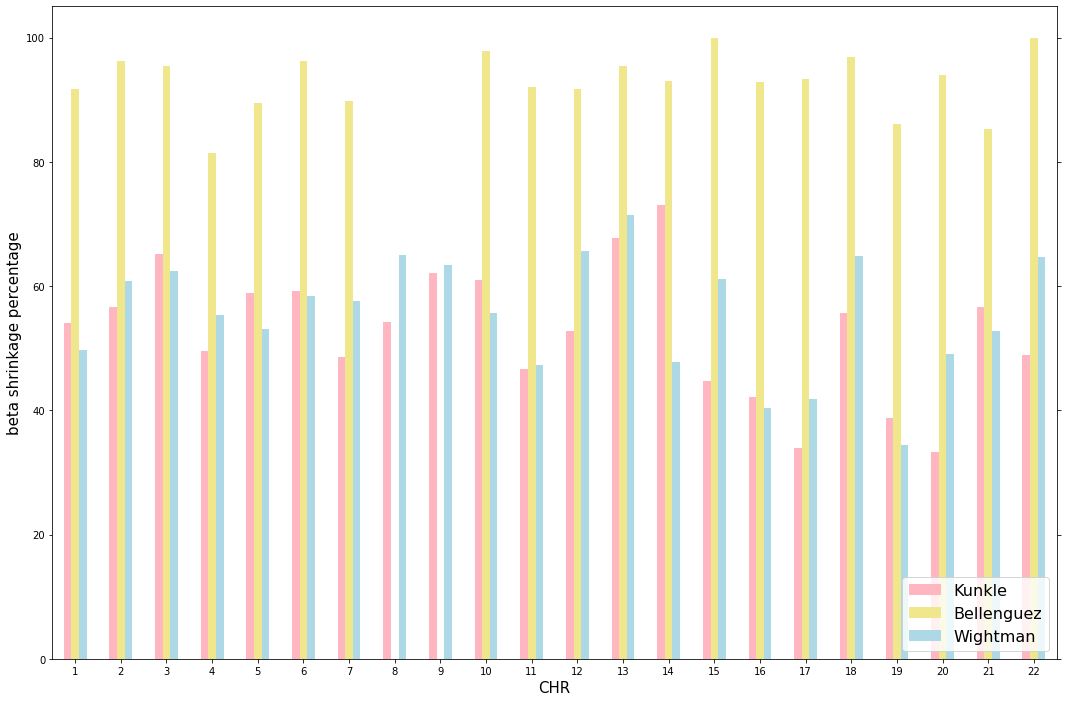

In [126]:
shrinkage_Rate.plot(kind='bar', color = ['lightpink','khaki','lightblue'])
plt.ylabel('beta shrinkage percentage',fontsize = 15)
plt.xlabel('CHR',fontsize = 15)
plt.xticks(rotation = 0)
plt.tick_params(bottom=True, top=False, left=True, right=True)

plt.legend(loc=4, prop={'size': 16})
fig = plt.gcf()
fig.set_size_inches(18, 12)
fig.savefig('/gpfs/commons/home/tlin/pic/others/beta_shrinkage_porpotion.pdf')
fig.savefig('/gpfs/commons/home/tlin/pic/others/beta_shrinkage_porpotion.png')


In [157]:
check_kunkle[0]['sumstat'] = 'kunkle'
check_bellenguez[0]['sumstat'] = 'bellenguez'
check_wightman[0]['sumstat'] = 'wightman'

check_bellenguez[0].to_csv('check_bellenguez_merge.tsv', sep = '\t', index = False)
check_bellenguez[1].tofile('bellenguez_snp.csv', sep = ',')

check_kunkle[1].tofile('kunkle_snp.csv', sep = ',')


check_wightman[1].tofile('wightman_snp.csv', sep = ',')
check_wightman[0].to_csv('check_wightman_merge.tsv', sep = '\t', index = False)
check_kunkle[0].to_csv('check_kunkle_merge.tsv', sep = '\t', index = False)

In [195]:
wightman_snp = pd.read_csv('wightman_snp.csv')
bellenguez_snp = pd.read_csv('bellenguez_snp.csv')
kunkle_snp = pd.read_csv('kunkle_snp.csv')

check_wightman = pd.read_csv('check__wightman_merge.tsv', sep = '\t')
check_bellenguez = pd.read_csv('check_bellenguez_merge.tsv', sep = '\t')

In [128]:
print(check_bellenguez[0].BP.shape)
print(check_bellenguez[0].SNP.drop_duplicates().shape)

(100,)
(32,)


In [129]:
check_bellenguez[0][0:20]

,A1,A2,BP,BP_distance,BP_inconsistent,CHR,FREQ1,HETISQ,HETPVAL,N,N_CAS,N_CON,P,PIP,SNP,STDERR,beta_polyfun,beta_sumstat
0,G,A,28736625.0,5524.0,28731101.0,1.0,0.2844,14.0,0.3069,487511.0,85934.0,401577.0,4.402000e-04,0.091476,rs11247809,0.0090,0.026804,0.0317
1,G,A,28736625.0,2966.0,28739591.0,1.0,0.2844,14.0,0.3069,487511.0,85934.0,401577.0,4.402000e-04,0.091476,rs11247809,0.0090,0.026804,0.0317
2,G,A,49087541.0,5528.0,49082013.0,1.0,0.5792,0.0,0.5446,487511.0,85934.0,401577.0,1.208000e-04,0.999993,rs320032,0.0083,0.068502,0.0321
3,G,A,49087541.0,334.0,49087207.0,1.0,0.5792,0.0,0.5446,487511.0,85934.0,401577.0,1.208000e-04,0.999993,rs320032,0.0083,0.068502,0.0321
4,G,A,49087541.0,4172.0,49091713.0,1.0,0.5792,0.0,0.5446,487511.0,85934.0,401577.0,1.208000e-04,0.999993,rs320032,0.0083,0.068502,0.0321
5,G,A,49087541.0,4586.0,49092127.0,1.0,0.5792,0.0,0.5446,487511.0,85934.0,401577.0,1.208000e-04,0.999993,rs320032,0.0083,0.068502,0.0321
6,A,G,84817170.0,8103.0,84809067.0,1.0,0.0616,21.1,0.2367,487511.0,85934.0,401577.0,1.049000e-04,1.000000,rs315539,0.0197,-0.088245,-0.0765
7,A,G,84817170.0,7784.0,84809386.0,1.0,0.0616,21.1,0.2367,487511.0,85934.0,401577.0,1.049000e-04,1.000000,rs315539,0.0197,-0.088245,-0.0765
8,A,G,84817170.0,7608.0,84809562.0,1.0,0.0616,21.1,0.2367,487511.0,85934.0,401577.0,1.049000e-04,1.000000,rs315539,0.0197,-0.088245,-0.0765
9,A,G,84817170.0,3063.0,84820233.0,1.0,0.0616,21.1,0.2367,487511.0,85934.0,401577.0,1.049000e-04,1.000000,rs315539,0.0197,-0.088245,-0.0765


In [ ]:
effect_snp = check_bellenguez.SNP.drop_duplicates()

In [22]:
## show the count of tagging SNPs with each causal SNPs in bellenguez

check_bellenguez[0].loc[:,["SNP", "CHR",'PIP','beta_polyfun','beta_sumstat']].value_counts()

SNP          CHR   PIP       beta_polyfun  beta_sumstat
rs11178373   12.0  1.000000   0.113452      0.0756         9
rs145329084  11.0  1.000000  -0.109396     -0.1091         8
rs6915987    6.0   0.999995   0.067854      0.0329         7
rs11607398   11.0  0.103048   0.023346      0.0360         6
rs315539     1.0   1.000000  -0.088245     -0.0765         5
rs12628367   22.0  0.018726   0.001787      0.0366         5
rs151199058  2.0   1.000000  -0.092549     -0.0461         5
rs921704     15.0  1.000000   0.055660      0.0294         4
rs17730467   14.0  0.012155  -0.023537     -0.0428         4
rs320032     1.0   0.999993   0.068502      0.0321         4
rs112639089  2.0   1.000000   0.076855      0.1197         3
rs141145715  16.0  1.000000  -0.077102     -0.1483         3
rs10000873   4.0   0.015692   0.006927      0.0319         3
rs62187612   2.0   0.087828   0.073755      0.0457         3
rs4302559    5.0   1.000000   0.091210      0.0303         3
rs7118963    11.0  1.000000  

In [155]:
np.array(check_bellenguez[0].loc[:,["SNP", "CHR","BP"]].value_counts().reset_index().iloc[:,-1])


array([9, 8, 7, 6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1])

SNP          CHR   BP         
rs11178373   12.0  71095567.0     9
rs145329084  11.0  85156639.0     8
rs6915987    6.0   27515776.0     7
rs11607398   11.0  104672916.0    6
rs315539     1.0   84817170.0     5
rs12628367   22.0  39717104.0     5
rs151199058  2.0   97851664.0     5
rs921704     15.0  100266007.0    4
rs17730467   14.0  84534299.0     4
rs320032     1.0   49087541.0     4
dtype: int64

In [8]:
check_wightman 

,A1,A2,BP,BP_distance,BP_inconsistent,CHR,MAF,N,P,PIP,SNP,Z,beta_polyfun,beta_sumstat,sumstat
0,A,G,86250544.0,2501.0,86248043.0,11.0,0.067068,761252.0,0.000288,0.013489,rs11234686,3.625932,0.000139,0.011747,wightman


In [168]:
result = merge_kunkle[(merge_kunkle.SNP.isin(check_kunkle[1])) & (merge_kunkle.PIP < 0.01)] 
result.loc['sumstat'] = 'kunkle'


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [194]:
np.append(check_bellenguez[1],check_bellenguez_2[1]).tofile('bellenguez_snp.csv', sep = ',')

In [166]:
pd.concat(result, result2, result3)

,SNP,CHR,BP,A1,A2,Z,P,N,MAF,beta_sumstat,PIP,beta_polyfun
28755,rs226476,1,7998963,T,G,1.558914,0.119017,758289,0.040976,0.006386,0.000073,3.597610e-07
68507,rs142556222,1,20000612,C,T,1.400644,0.161321,743305,0.014002,0.009776,0.000367,1.418890e-06
87528,rs76621150,1,25998779,T,C,-0.638728,0.523000,364859,0.004965,-0.010637,0.000113,-2.043830e-07
155211,rs187437588,1,49002312,G,A,-2.197707,0.027970,364112,0.005410,-0.035089,0.000145,-1.064170e-06
155217,rs1113487,1,49003256,C,T,2.546526,0.010880,726258,0.084008,0.007617,0.000308,2.614000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
9146596,rs12484628,22,46002768,C,T,1.497957,0.134145,761954,0.088622,0.004270,0.000149,6.289980e-07
9154712,rs6007701,22,47995497,C,T,-2.009527,0.044481,565280,0.036250,-0.010111,0.000304,-1.729120e-06
9154726,rs9615555,22,47999239,G,A,0.385185,0.700100,63926,0.114524,0.003383,0.000068,7.471910e-08
9165884,rs9628072,22,50000058,G,A,0.728763,0.466146,752662,0.025016,0.003803,0.000042,8.695860e-08


Text(0.5, 1.0, 'Wightman')

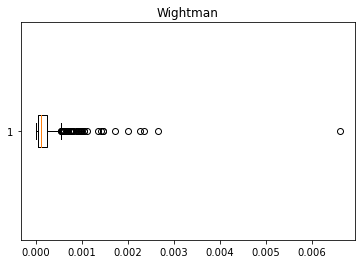

In [74]:
plt.boxplot(test.PIP, vert=False)
plt.title('Wightman')